In [25]:
import pandas as pd
import os
from glob import glob

In [26]:
label_df = pd.read_csv('./data/train.csv')
label_df

,file_name,label
0,001.PNG,9
1,002.PNG,4
2,003.PNG,1
3,004.PNG,1
4,005.PNG,6
...,...,...
718,719.PNG,9
719,720.PNG,6
720,721.PNG,2
721,722.PNG,8


In [27]:
a = glob('./data/train/*')
a.sort(key=lambda x: x.split('/')[-1].split('./')[0])
a

['./data/train/001.PNG',
 './data/train/002.PNG',
 './data/train/003.PNG',
 './data/train/004.PNG',
 './data/train/005.PNG',
 './data/train/006.PNG',
 './data/train/007.PNG',
 './data/train/008.PNG',
 './data/train/009.PNG',
 './data/train/010.PNG',
 './data/train/011.PNG',
 './data/train/012.PNG',
 './data/train/013.PNG',
 './data/train/014.PNG',
 './data/train/015.PNG',
 './data/train/016.PNG',
 './data/train/017.PNG',
 './data/train/018.PNG',
 './data/train/019.PNG',
 './data/train/020.PNG',
 './data/train/021.PNG',
 './data/train/022.PNG',
 './data/train/023.PNG',
 './data/train/024.PNG',
 './data/train/025.PNG',
 './data/train/026.PNG',
 './data/train/027.PNG',
 './data/train/028.PNG',
 './data/train/029.PNG',
 './data/train/030.PNG',
 './data/train/031.PNG',
 './data/train/032.PNG',
 './data/train/033.PNG',
 './data/train/034.PNG',
 './data/train/035.PNG',
 './data/train/036.PNG',
 './data/train/037.PNG',
 './data/train/038.PNG',
 './data/train/039.PNG',
 './data/train/040.PNG',


In [28]:
def load_data(test:bool):
    if test==True:
        test_file_list = glob('./data/test/*')
        test_file_list.sort(key=lambda x: x.split('/')[-1].split('.')[0])
        return test_file_list
    
    else:
        label_list = []
        
        train_file_list = glob('./data/train/*')
        train_file_list.sort(key=lambda x: x.split('/')[-1].split('.')[0])
        
        label_list.extend(label_df['label'])
        
        return train_file_list, label_list

In [29]:
train_file_list, label_list = load_data(test=False)
test_file_list = load_data(test=True)

In [30]:
train_file_list[:5]

['./data/train/001.PNG',
 './data/train/002.PNG',
 './data/train/003.PNG',
 './data/train/004.PNG',
 './data/train/005.PNG']

In [31]:
label_list[:5]

[9, 4, 1, 1, 6]

In [8]:
test_file_list[:5]

['./data/test/001.PNG',
 './data/test/002.PNG',
 './data/test/003.PNG',
 './data/test/004.PNG',
 './data/test/005.PNG']

In [9]:
import torch
import torch.nn as nn

device = 'mps' if torch.backends.mps.is_available() else 'cpu'
device

'mps'

In [10]:
cfg = {'IMG_SIZE':128,
       'EPOCHS':50,
       'LEARNING_RATE':2e-2,
       'BATCH_SIZE':12,
       'SEED':41}

In [11]:
import random
import numpy as np

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
seed_everything(cfg['SEED'])

In [12]:
cfg

{'IMG_SIZE': 128,
 'EPOCHS': 50,
 'LEARNING_RATE': 0.02,
 'BATCH_SIZE': 12,
 'SEED': 41}

In [13]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from torch.utils.data import DataLoader, Dataset
import cv2

In [14]:
class CustomDataset(Dataset):
    def __init__(self, img_path_list, label_list, train_mode=True, transforms=None):
        self.transforms = transforms
        self.train_mode = train_mode
        self.img_path_list = img_path_list
        self.label_list = label_list
        
    def __getitem__(self, index): # index번째 data return
        img_path = self.img_path_list[index]
        img = cv2.imread(img_path)
        
        if self.transforms is not None:
            img = self.transforms(img)
            
        if self.train_mode:
            label = self.label_list[index]
            return img, label
        
        else:
            return img
        
    def __len__(self):
        return len(self.img_path_list)

In [15]:
temp_dataset = CustomDataset(img_path_list=train_file_list,
                             label_list=label_list,
                             train_mode=False)

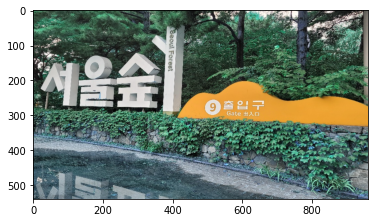

In [16]:
import matplotlib.pyplot as plt

plt.imshow(temp_dataset.__getitem__(0))

In [17]:
# train validation split

train_len = int(len(train_file_list)*0.75)
val_len = int(len(train_file_list)*0.25)

train_img_path = train_file_list[:train_len]
train_label = label_list[:train_len]
val_img_path = train_file_list[train_len:]
val_label = label_list[train_len:]

In [18]:
print(train_len, val_len)

542 180


In [19]:
len(val_label)

181

In [20]:
# transform images

train_transform = transforms.Compose([transforms.ToPILImage(), # numpy -> PIL image
                                      transforms.Resize([cfg['IMG_SIZE'], cfg['IMG_SIZE']]),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])

val_transform = transforms.Compose([transforms.ToPILImage(),
                                    transforms.Resize([cfg['IMG_SIZE'], cfg['IMG_SIZE']]),
                                    transforms.ToTensor(), # image data -> tensor
                                    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])

In [21]:
# DataLoader

train_dataset = CustomDataset(img_path_list=train_img_path,
                              label_list=train_label,
                              train_mode=True,
                              transforms=train_transform)
train_loader = DataLoader(train_dataset,
                          batch_size=cfg['BATCH_SIZE'],
                          shuffle=True,
                          num_workers=0)
train_batches = len(train_loader)

val_dataset = CustomDataset(img_path_list=val_img_path,
                            label_list=val_label,
                            train_mode=True,
                            transforms=val_transform)
val_loader = DataLoader(val_dataset,
                        batch_size=cfg['BATCH_SIZE'],
                        shuffle=False,
                        num_workers=0)
val_batches = len(val_loader)

In [22]:
len(train_dataset)

542

In [23]:
print(f'total train img: {len(train_dataset)} / total train batches: {train_batches}')
print(f'total val img: {len(val_dataset)} / total val batches: {val_batches}')

total train img: 542 / total train batches: 46
total val img: 181 / total val batches: 16


In [24]:
# build model

from tqdm.auto import tqdm
import torch.nn as nn

class CNNClassifier(torch.nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()
        
        self.layer1 = nn.Sequential(nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer3 = nn.Sequential(nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer4 = nn.Sequential(nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc_layer = nn.Sequential(nn.Linear(4096, 10))
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = torch.flatten(x, start_dim=1) # n-dimension -> 1-D
        out = self.fc_layer(x)
        
        return out

In [25]:
import torch.optim as optim

model = CNNClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(params=model.parameters(), lr=cfg['LEARNING_RATE'])
scheduler = None

In [26]:
# model training

def train(model, optimizer, train_loader, scheduler, device):
    model.to(device)
    n = len(train_loader)
    best_acc = 0
    
    for epoch in range(1, cfg['EPOCHS']+1):
        model.train() # set model to training mode
        running_loss = 0.0
        
        for img, label in tqdm(iter(train_loader)):
            img, label = img.to(device), label.to(device)
            optimizer.zero_grad()
            
            # fit data to model -> output
            logit = model(img)
            loss = criterion(logit, label)
            
            # backward
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
        print('[%d] Train Loss: %.10f'%(epoch, running_loss/len(train_loader)))
        
        if scheduler is not None:
            scheduler.step()
            
        
        # validation
        model.eval()
        val_loss = 0.0
        correct = 0
        with torch.no_grad():
            for img, label in tqdm(iter(val_loader)):
                img, label = img.to(device), label.to(device)
                
                logit = model(img)
                val_loss += criterion(logit, label)
                pred = logit.argmax(dim=1, keepdim=True) # 11개 클래스 중 값이 가장 높은 것을 label로 예측
                correct += pred.eq(label.view_as(pred)).sum().item() # 예측값이 맞으면 1, 틀리면 0
        
        val_acc = 100*correct/len(val_loader.dataset)
        print(f'Val - Loss: {val_loss/len(val_loader)}, ACC: {correct}/{len(val_loader.dataset)}({100*correct/len(val_loader.dataset):.2f}%)')
        
        # save best model
        if best_acc < val_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), './data/saved/best_model.pth')
            print('Model Saved')

In [27]:
train(model=model,
      optimizer=optimizer,
      train_loader=train_loader,
      scheduler=scheduler,
      device=device)

  0%|          | 0/46 [00:00<?, ?it/s]

[1] Train Loss: 2.3042766374


  0%|          | 0/16 [00:00<?, ?it/s]

Val - Loss: 2.305135726928711, ACC: 14/181(7.73%)
Model Saved


  0%|          | 0/46 [00:00<?, ?it/s]

[2] Train Loss: 2.2925253796


  0%|          | 0/16 [00:00<?, ?it/s]

Val - Loss: 2.297433853149414, ACC: 14/181(7.73%)


  0%|          | 0/46 [00:00<?, ?it/s]

[3] Train Loss: 2.2467865788


  0%|          | 0/16 [00:00<?, ?it/s]

Val - Loss: 2.171560525894165, ACC: 44/181(24.31%)
Model Saved


  0%|          | 0/46 [00:00<?, ?it/s]

[4] Train Loss: 1.7233713580


  0%|          | 0/16 [00:00<?, ?it/s]

KeyboardInterrupt: 

### https://jisuhan.tistory.com/entry/Pytorch%EB%A5%BC-%EC%9D%B4%EC%9A%A9%ED%95%9C-Image-Classifier-%EC%BD%94%EB%93%9C-%EB%B6%84%EC%84%9D

In [34]:
import numpy as np
import pandas as pd
import torch
from torch import optim
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor, ToPILImage
from PIL import Image
import matplotlib.pyplot as plt

from glob import glob

In [18]:
import pandas as pd

labels_train = pd.read_csv('./data/train.csv')
labels_test = pd.read_csv('./data/test.csv')

In [19]:
labels_test

,file_name
0,001.PNG
1,002.PNG
2,003.PNG
3,004.PNG
4,005.PNG
...,...
194,195.PNG
195,196.PNG
196,197.PNG
197,198.PNG


In [20]:
def load_data(test:bool):
    if test == False:
        labels = []
        data = glob('./data/train/*')
        data.sort(key=lambda x: x.split('/')[-1].split('.')[0])
        labels.extend(labels_train['label'])
        return data, labels
        
    else:
        data = glob('./data/test/*')
        data.sort(key=lambda x: x.split('/')[-1].split('.')[0])
        return data

In [21]:
import shutil
import os

def move_file_paths(df):
    for data, label in zip(df.data, df.label):
        if os.path.isdir(f'./data/train/{label}') == False:
            os.mkdir(f'./data/train/{label}')
            shutil.move(data, f'./data/train/{label}')
        else:
            shutil.move(data, f'./data/train/{label}')

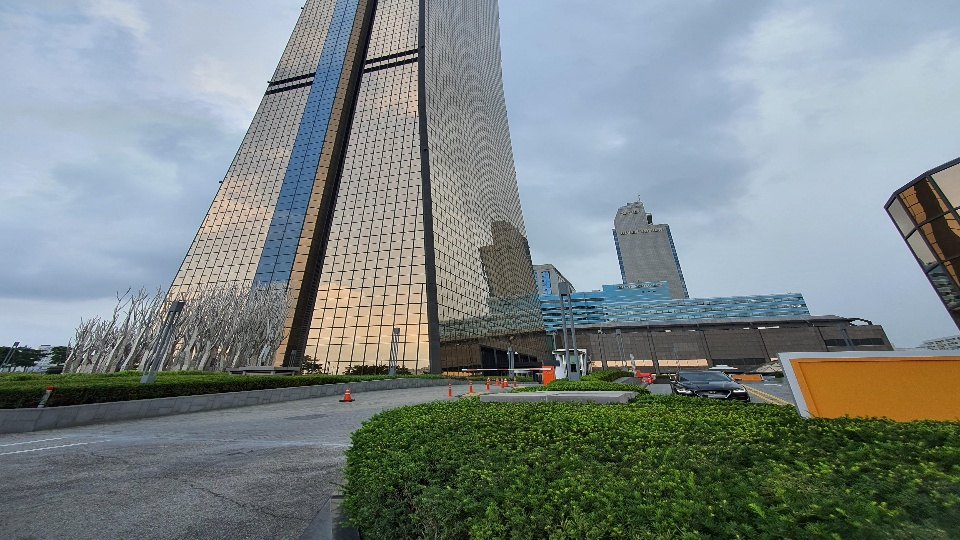

In [22]:
img = Image.open('./data/train/0/058.PNG').convert('RGB')
img

In [40]:
transform = transforms.Compose(
    [transforms.Resize((100,100)),
     transforms.ToTensor(),
     transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))]
)

batch_size = 16

train = torchvision.datasets.ImageFolder(root='./data/train/', transform=transform)
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=2)
# test = torchvision.datasets.ImageFolder('./data/test/')
# test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False, num_workers=2)

In [24]:
train.__getitem__(282)

(tensor([[[-0.1765, -0.1686, -0.1686,  ..., -0.3333, -0.3412, -0.3412],
          [-0.1686, -0.1686, -0.1686,  ..., -0.3333, -0.3412, -0.3490],
          [-0.1608, -0.1686, -0.1686,  ..., -0.3412, -0.3333, -0.3412],
          ...,
          [-0.4196, -0.6784, -0.8353,  ..., -0.2706, -0.6627, -0.7882],
          [-0.5451, -0.6941, -0.8588,  ..., -0.2706, -0.5137, -0.7647],
          [-0.6706, -0.8196, -0.8902,  ..., -0.2784, -0.4745, -0.6157]],
 
         [[ 0.1608,  0.1686,  0.1686,  ...,  0.0431,  0.0353,  0.0353],
          [ 0.1686,  0.1686,  0.1686,  ...,  0.0431,  0.0431,  0.0353],
          [ 0.1765,  0.1686,  0.1686,  ...,  0.0510,  0.0510,  0.0431],
          ...,
          [-0.4275, -0.6941, -0.8431,  ..., -0.2314, -0.6078, -0.7098],
          [-0.5529, -0.7098, -0.8667,  ..., -0.2392, -0.4510, -0.6863],
          [-0.6784, -0.8275, -0.8902,  ..., -0.2549, -0.4118, -0.5373]],
 
         [[ 0.5608,  0.5686,  0.5686,  ...,  0.5294,  0.5216,  0.5216],
          [ 0.5686,  0.5686,

In [25]:
train.classes

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [26]:
images, labels = iter(train_loader).next()

In [27]:
images.shape

torch.Size([16, 3, 200, 200])

In [28]:
def imshow(img):
    img = img/2 +0.5 # denormalize
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    
    print(np_img.shape)
    print(np.transpose(np_img, (1, 2, 0)).shape)

(3, 810, 810)
(810, 810, 3)


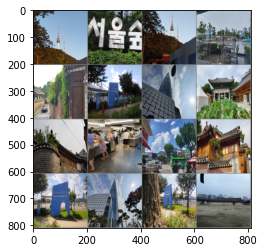

In [29]:
imshow(torchvision.utils.make_grid(images, nrow=4))

In [61]:
class My_Net(nn.Module):
    def __init__(self):
        super().__init__() # 부모 클래스의 메소드 오버로딩
        # in_channels: input channels    out_channels: is equal to number of filters     kernel_size: kernel=filter, size of kernel
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.pool = nn.MaxPool2d(2,2) # max pooling size of 2X2
        self.conv2 = nn.Conv2d(6, 16, 5) # in_channels must match to previous conv out channels
        self.fc1 = nn.Linear(in_features=16*5*5, out_features=128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        
    def forward(self, x):
        # x = x.view(x.size(0), -1)
        x = self.conv1(x)
        x = self.pool(F.relu(x))
        x = self.conv2(x)
        x = self.pool(x)
        x = torch.flatten(input=x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        out = self.fc3(x)
        
        return out

In [62]:
net = My_Net()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [63]:
net.parameters

<bound method Module.parameters of My_Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)>

In [64]:
train_loader.dataset

Dataset ImageFolder
    Number of datapoints: 723
    Root location: ./data/train/
    StandardTransform
Transform: Compose(
               Resize(size=(100, 100), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [65]:
for epoch in range(2):
    running_loss = 0.0
    
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        
        optimizer.zero_grad()
        
        '''
        gradient descent process
            0) forward propagation
            1) calculate Loss
            2) calculate gradients(derivatives)
            3) execute backward propagation(=optimization)
        '''
        outputs = net(inputs) # 0) forward
        loss = criterion(outputs, labels) # 1) loss calculation
        loss.backward() # 2) gradients calculation
        optimizer.step() # 3) backward
        
        # 결과 출력
        running_loss += loss.item()
        if i % 100 == 99:
            print('[epoch: %d, %5d] Loss = %.3f' %(epoch+1, i+1, running_loss/100))
            running_loss = 0.0
            
print('finished training!')

RuntimeError: mat1 and mat2 shapes cannot be multiplied (16x7744 and 400x128)